# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [55]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [56]:
path = '/Users/yuqingdai/Documents/GitHub/Stock-Erdos/scratch work/Yuqing-Data-Merge/Data/dt'


In [57]:
df= pd.read_csv(path+'/dff1.csv')
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df = df[['ds', 'y', 'fbsp','diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 
       'wti', 'ppi', 'rfs']]
# df

In [58]:
df['fbsp_tby'] = df['fbsp'] * df['tby']
df['fbsp_ffr'] = df['fbsp'] * df['ffr']
df['fbsp_div'] = df['fbsp'] * df['div']
df['eps_tby'] = df['eps'] * df['tby']
df['eps_ffr'] = df['eps'] * df['ffr']
df['eps_div'] = df['eps'] * df['div']



In [59]:
cutoff = len(df) - 252
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

In [60]:
cutoff

2300

In [61]:
df_train.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div'],
      dtype='object')

In [62]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div']

from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


#print(list(powerset(possible_features)))

In [63]:
len(possible_features)

15

In [64]:
from statsmodels.regression.linear_model import OLS

reg_new = OLS((df_train['diff']).copy(),df_train[possible_features].copy()).fit()
print(reg_new.params)

#from the output, we can see it's consistent with sklearn output

tby         314.386042
ffr         213.418347
fta           0.000034
eps          -0.077519
div        -124.163094
une         -86.563530
wti           3.380573
ppi          -7.973545
rfs           0.006123
fbsp_tby     -0.047647
fbsp_ffr     -0.048211
fbsp_div     -0.376103
eps_tby      -2.147124
eps_ffr      -0.045521
eps_div       3.436582
dtype: float64


In [65]:
new_coef = reg_new.params
new_possible_feats = new_coef[abs(new_coef)>0].index

power_feats = list(powerset(new_possible_feats))
power_feats.remove(())

power_feats = [ list(feats) for feats in power_feats]
len(power_feats)


32767

In [66]:
AIC_scores = []
parameters = []

for feats in power_feats:
    tmp_reg = OLS((df_train['diff']).copy(),df_train[feats].copy()).fit()
    AIC_scores.append(tmp_reg.aic)
    parameters.append(tmp_reg.params)

    
Min_AIC_index = AIC_scores.index(min(AIC_scores))
Min_AIC_feats = power_feats[Min_AIC_index]  
Min_AIC_params  = parameters[Min_AIC_index]
print(Min_AIC_feats)
print(Min_AIC_params)  

['tby', 'ffr', 'fta', 'div', 'une', 'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_div']
tby         314.523389
ffr         212.412618
fta           0.000034
div        -120.948180
une         -86.827104
wti           3.387615
ppi          -7.982076
rfs           0.006115
fbsp_tby     -0.047797
fbsp_ffr     -0.050024
fbsp_div     -0.375708
eps_tby      -2.147141
eps_div       3.396462
dtype: float64


In [67]:
len(Min_AIC_feats)

13

In [68]:
###After selecting the best features, we report the testing error, and make the plot 
AIC_df_test = df_test[Min_AIC_feats]
AIC_pred_test = AIC_df_test.dot(Min_AIC_params)+df_test.fbsp

AIC_df_train = df_train[Min_AIC_feats]
AIC_pred_train = AIC_df_train.dot(Min_AIC_params)+ df_train.fbsp



In [69]:
from sklearn.metrics import mean_squared_error as MSE

mse_train = MSE(df_train.y, AIC_pred_train) 
mse_test = MSE(df_test.y, AIC_pred_test)


#compare with fbprophet()

fb_mse_train = MSE(df_train.y, df_train.fbsp) 
fb_mse_test = MSE(df_test.y, df_test.fbsp)


print(mse_train,fb_mse_train)

print(mse_test,fb_mse_test)

2555.498643251355 17643.826224878187
9616.614211316908 15046.462930803766


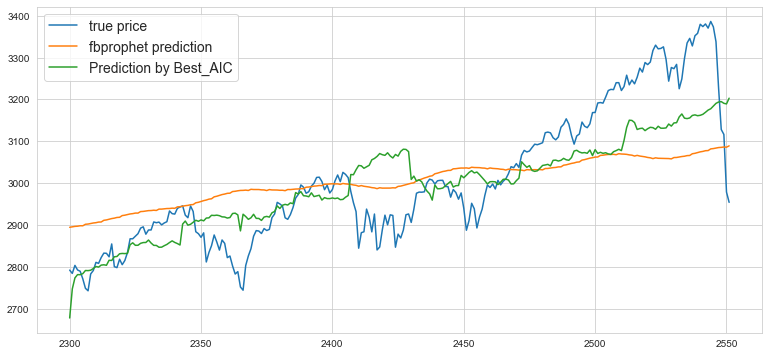

In [70]:
plt.figure(figsize=(13,6))
plt.plot(df_test.y,label="true price")
plt.plot(df_test.fbsp,label="fbprophet prediction")
plt.plot(AIC_pred_test,label="Prediction by Best_AIC")
plt.legend(fontsize = 14)
plt.show()